In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *

import wandb

In [3]:
model_name = 'MNetV2-224x398-3000L'

In [4]:
#hide
wandb.init(name='MNetV2-224x398',
           project='Shot Framing -- Supervised (3000L)',
           tags=['MobileNetV2'],
           entity='synopsis',
           resume='tg684qve')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/tg684qve

Streaming file created twice in same run: /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/wandb-history.jsonl
Streaming file created twice in same run: /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/wandb-events.jsonl


In [5]:
#hide
%env WANDB_NOTEBOOK_NAME='05-3-MNetV2-224x398-3000L.ipynb'

env: WANDB_NOTEBOOK_NAME='05-3-MNetV2-224x398-3000L.ipynb'


## Setup

### Dataset

Data grabbing functions in `CinemaNet/data_3000L.py`

In [6]:
img_size   = to_film_ar(224)
img_size

(224, 398)

In [7]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398)
y: CategoryList
Medium,Medium,Medium Close-Up,Close-Up,Extreme Wide
Path: .;

Test: None

6

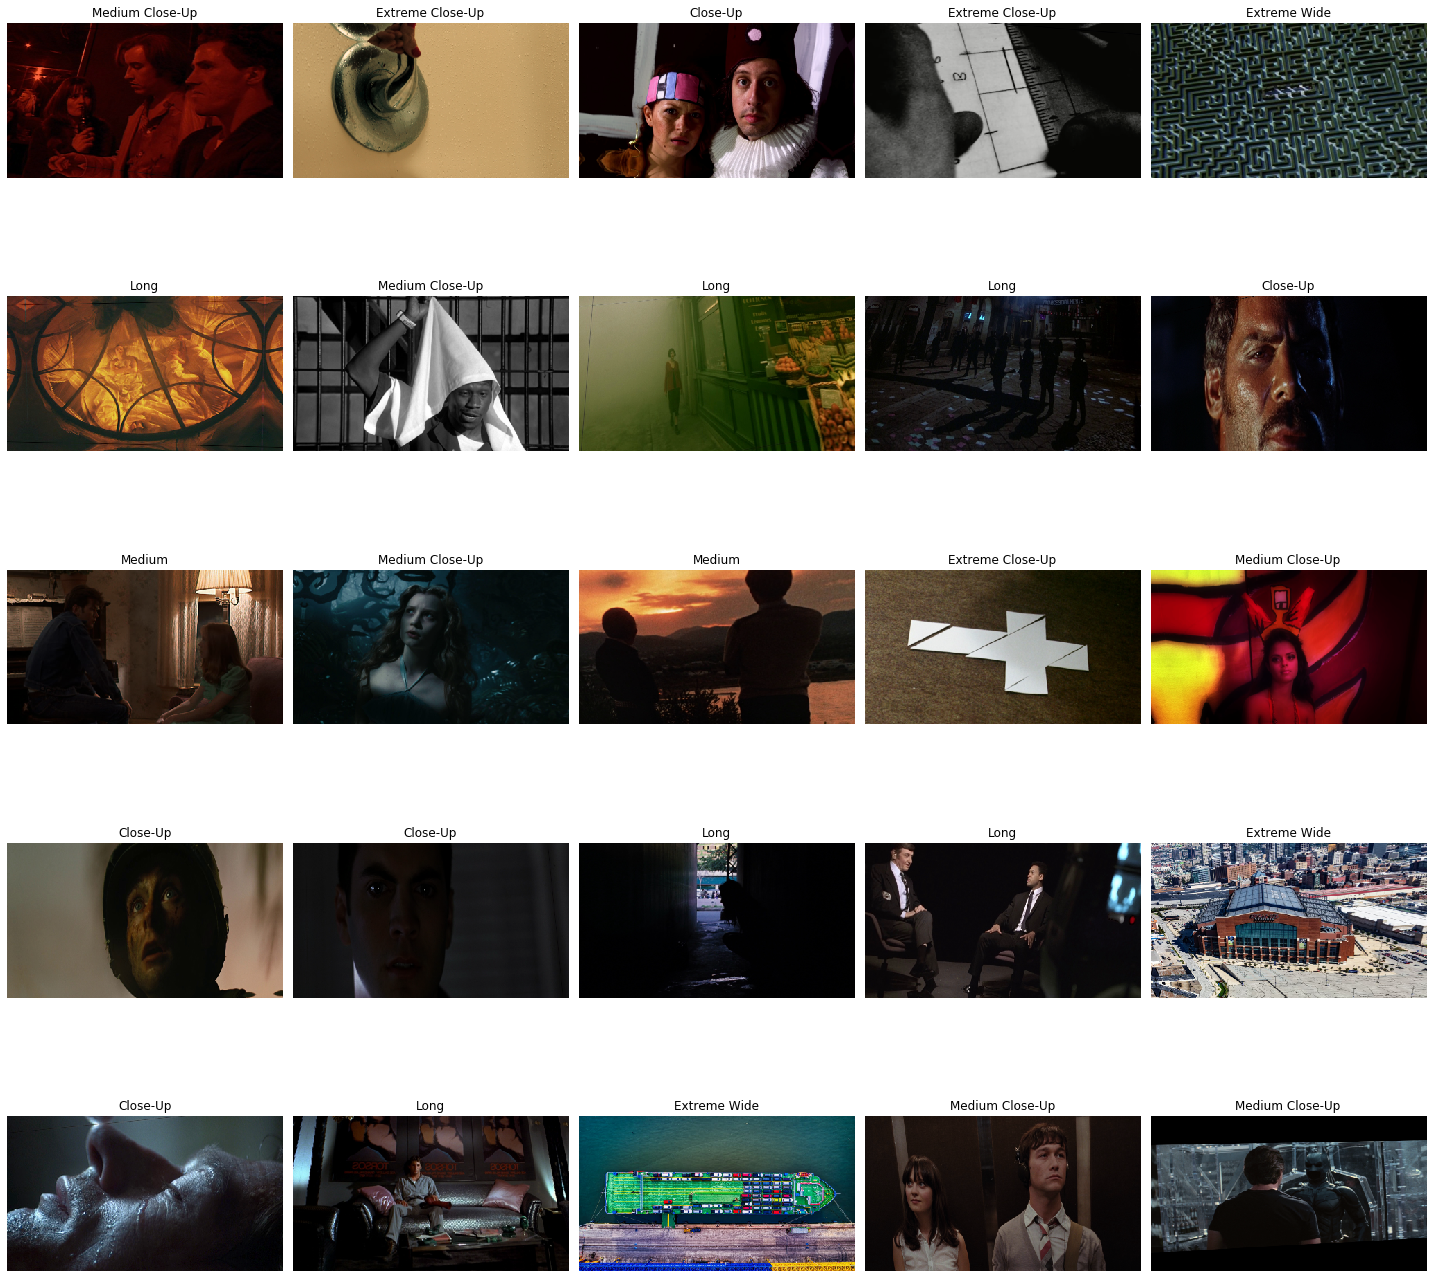

In [8]:
data.c
data.show_batch()

## Training (150, 266)

### Frozen -- Head Only

In [11]:
arch = models.mobilenet_v2
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics).to_fp16()

In [10]:
learn.data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398),Image (3, 224, 398)
y: CategoryList
Extreme Close-Up,Medium,Medium Close-Up,Close-Up,Close-Up
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


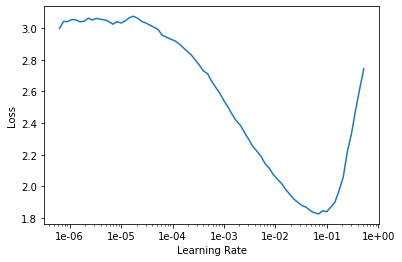

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}', monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [13]:
model_name

'MNetV2-224x398-3000L'

In [16]:
callbacks = get_callbacks(learn, model_name, early_stop=False)

In [17]:
len(learn.layer_groups)

3

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.358530,0.629686,0.789050,0.797033,0.813391,00:46
1,0.850057,0.662986,0.810306,0.800356,0.841987,00:44
2,0.578536,0.607561,0.820612,0.830306,0.851401,00:46
3,0.443336,0.408523,0.850886,0.865833,0.876652,00:45
4,0.330779,0.425148,0.853462,0.847436,0.872398,00:48
5,0.245804,0.371026,0.871820,0.883025,0.886171,00:50
6,0.177980,0.380357,0.873430,0.874548,0.894004,00:52
7,0.149169,0.369191,0.875684,0.876808,0.895896,00:47


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7890499234199524.
Better model found at epoch 0 with accuracy value: 0.7890499234199524.
Better model found at epoch 1 with accuracy value: 0.8103059530258179.
Better model found at epoch 1 with accuracy value: 0.8103059530258179.
Better model found at epoch 2 with accuracy value: 0.8206118941307068.
Better model found at epoch 2 with accuracy value: 0.8206118941307068.
Better model found at epoch 3 with accuracy value: 0.8508856892585754.
Better model found at epoch 3 with accuracy value: 0.8508856892585754.
Better model found at epoch 4 with accuracy value: 0.8534621596336365.
Better model found at epoch 4 with accuracy value: 0.8534621596336365.
Better model found at epoch 5 with accuracy value: 0.8718196749687195.
Better model found at epoch 5 with accuracy value: 0.8718196749687195.
Better model found at epoch 6 with accuracy value: 0.8734299540519714.
Better model found at epoch 6 with accuracy value: 0.8734299540519714.
Better

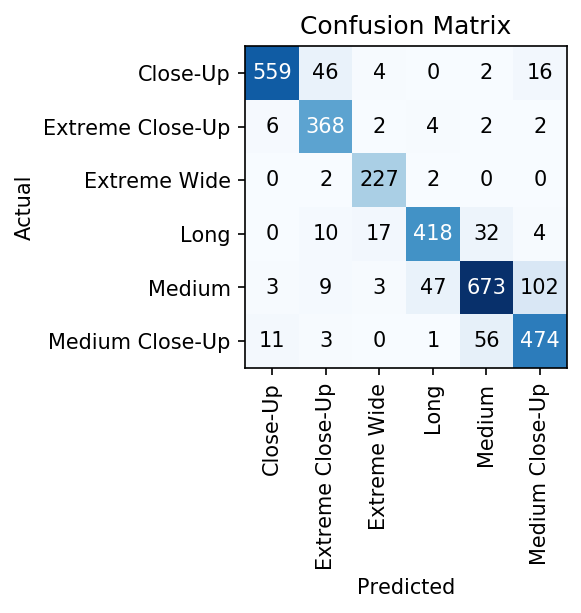

In [18]:
learn.fit_one_cycle(8, 3e-3, callbacks=callbacks)

### Unfrozen

In [19]:
model_name

'MNetV2-224x398-3000L'

In [20]:
learn.unfreeze()
model_name = f'{model_name}-unfrozen'
callbacks = get_callbacks(learn, model_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


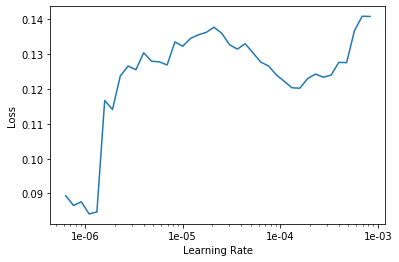

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
callbacks = get_callbacks(learn, model_name, early_stop=False)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.126534,0.370655,0.876006,0.876419,0.896150,00:49
1,0.112141,0.374198,0.876006,0.876393,0.896755,00:51
2,0.103219,0.363095,0.877939,0.880931,0.896900,00:48
3,0.121366,0.367205,0.874396,0.876244,0.893975,00:49
4,0.123581,0.376501,0.875684,0.876238,0.896651,00:48
5,0.117961,0.373481,0.878261,0.878038,0.898526,00:50
6,0.120891,0.372380,0.873752,0.874578,0.893773,00:49
7,0.121103,0.373562,0.875684,0.877303,0.896055,00:53
8,0.117471,0.371024,0.875362,0.876305,0.895378,00:52
9,0.118648,0.361439,0.879549,0.881879,0.899264,00:49


Better model found at epoch 0 with accuracy value: 0.8760064244270325.
Better model found at epoch 0 with accuracy value: 0.8760064244270325.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 2 with accuracy value: 0.8779388070106506.
Better model found at epoch 2 with accuracy value: 0.8779388070106506.
Better model found at epoch 5 with accuracy value: 0.8782608509063721.
Better model found at epoch 5 with accuracy value: 0.8782608509063721.
Better model found at epoch 9 with accuracy value: 0.8795490860939026.
Better model found at epoch 9 with accuracy value: 0.8795490860939026.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_060353-tg684qve/bestmodel.pth


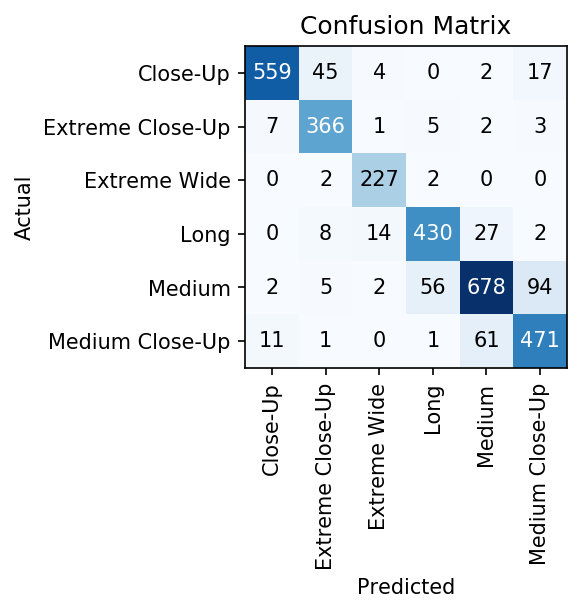

In [23]:
learn.fit_one_cycle(12, slice(1e-6), callbacks=callbacks)

In [ ]:
config = wandb.config

config.img_size = img_size

In [12]:
config.batch_size = learn.data.batch_size
config.len_train = len(learn.data.train_ds)
config.len_valid = len(learn.data.valid_ds)
config.model = re.sub('-unfrozen', '', model_name)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


### Export to CoreML

In [13]:
from CinemaNet.convert import *
from CinemaNet.custom_head import *

In [14]:
model_name

'MNetV2-224x398-3000L'

In [16]:
learn = cnn_learner(data, arch)
learn.load(f'{model_name}-unfrozen');

In [17]:
model_fname=re.sub('-unfrozen.*', '', model_name)
model_fname

'MNetV2-224x398-3000L'

In [18]:
torch_to_coreml(learn.model, data.c,
                model_fname=model_fname,
                img_size=img_size)

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Converting Node Type Add
26/162: Converting Node Type Conv


In [19]:
!ls -l ../{model_fname}*

-rw-rw-r-- 1 rahul rahul 483 Jan 21 11:42 ../MNetV2-224x398-3000L-history.csv
-rw-rw-r-- 1 rahul rahul 697 Jan 21 11:57 ../MNetV2-224x398-3000L-unfrozen-history.csv


In [20]:
!ls -l ../exported-models/{model_fname}*

-rw-rw-r-- 1 rahul rahul 14346850 Jan 21 12:59 ../exported-models/MNetV2-224x398-3000L.mlmodel
-rw-rw-r-- 1 rahul rahul 14357317 Jan 21 12:59 ../exported-models/MNetV2-224x398-3000L.onnx


In [21]:
wandb.save(f'../exported-models/{model_fname}*')
wandb.save(f'../{model_fname}*')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/MNetV2-224x398-3000L.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/MNetV2-224x398-3000L.mlmodel']

['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/MNetV2-224x398-3000L-unfrozen-history.csv',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200121_072615-tg684qve/MNetV2-224x398-3000L-history.csv']